# Normalization vs Transformation (California Housing Dataset)

**Objective**: Compare the impact of normalization (MinMaxScaler) and transformation (Log/BoxCox) on model performance.

## Dataset Overview + EDA

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB
None
          longitude      latitude  housing_median_age   total_rooms   
count  20433.000000  20433.000000        20433.000000  20433.000000  \
mean    -119.570689     35.633221           28.633094   2636.504233   
std        2.003578      2.136348     

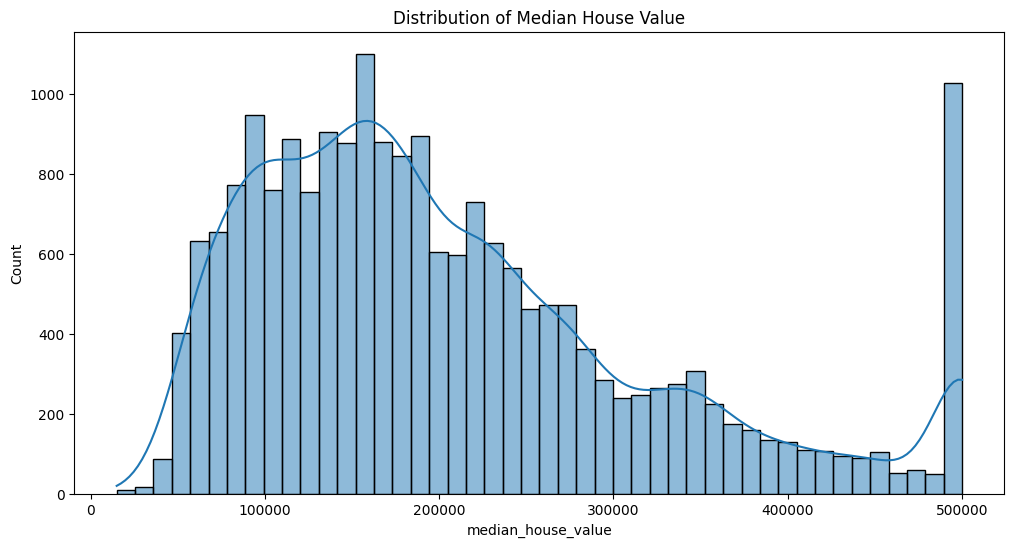

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('D:/ChaitanyaKhot-96/housing.csv')
df.dropna(inplace=True)

# Basic info
print(df.info())
print(df.describe())

# Visualize distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['median_house_value'], kde=True)
plt.title("Distribution of Median House Value")
plt.show()

## Preprocessing

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
import numpy as np

# Features and target
X = df.drop('median_house_value', axis=1)._get_numeric_data()
y = df['median_house_value']

# Log transform target for normality
log_transformer = FunctionTransformer(np.log1p, validate=True)
y_log = log_transformer.fit_transform(y.values.reshape(-1,1)).ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Normalize features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Building (Linear Regression vs Random Forest with Normalization/Transformation)

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Linear model on scaled data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Random Forest on raw (non-scaled) data
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## Performance Metrics

Linear Regression (MinMax + Log Target)
RMSE: 0.34209648276696975
R² Score: 0.6491099570856402

Random Forest (Raw Features + Log Target)
RMSE: 0.2291727725289407
R² Score: 0.8425292615103268


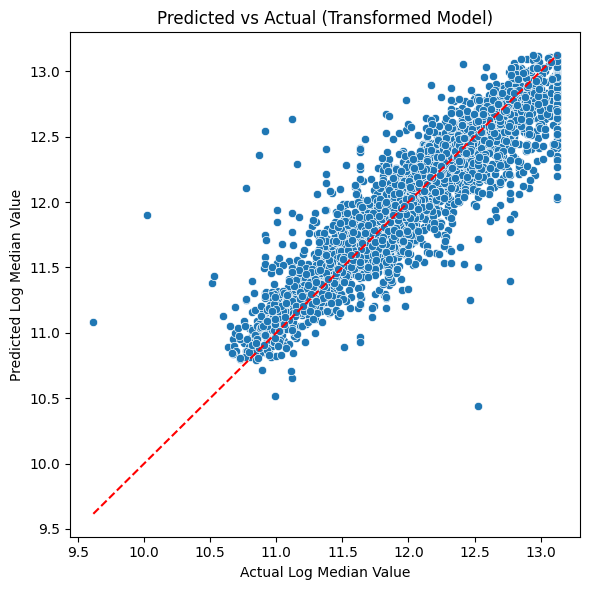

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
lr_preds = lr.predict(X_test_scaled)
rf_preds = rf.predict(X_test)

# Metrics
print("Linear Regression (MinMax + Log Target)")
print("RMSE:", mean_squared_error(y_test, lr_preds, squared=False))
print("R² Score:", r2_score(y_test, lr_preds))

print("\nRandom Forest (Raw Features + Log Target)")
print("RMSE:", mean_squared_error(y_test, rf_preds, squared=False))
print("R² Score:", r2_score(y_test, rf_preds))

# First, make predictions using the transformed model (Random Forest here)
y_pred_trans = rf.predict(X_test)

# Now you can safely plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_trans)
plt.xlabel("Actual Log Median Value")
plt.ylabel("Predicted Log Median Value")
plt.title("Predicted vs Actual (Transformed Model)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.tight_layout()
plt.show()

## Visualization: Residual Plots

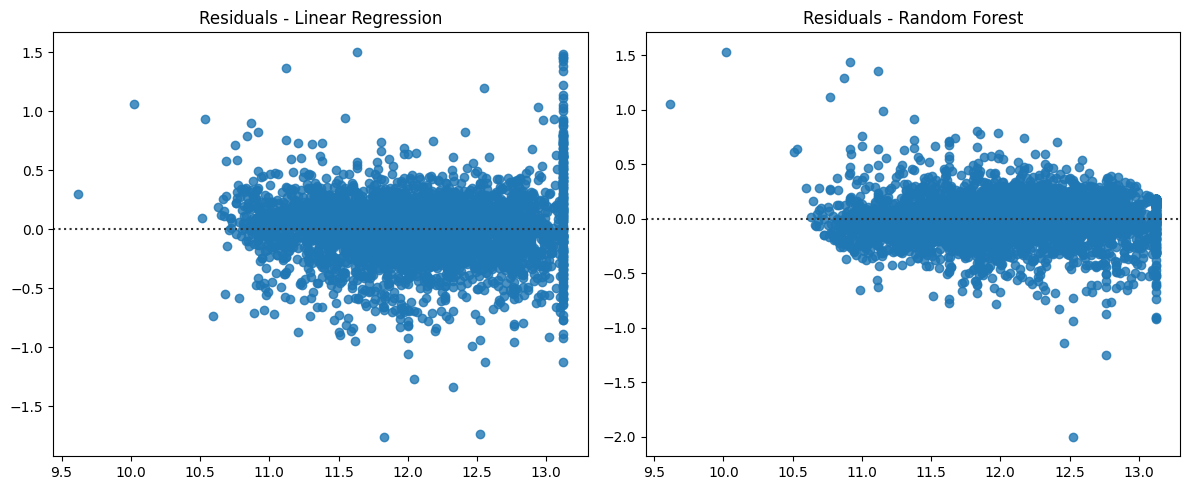

In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
sns.residplot(x=y_test, y=lr_preds, line_kws={'color': 'red'})
plt.title("Residuals - Linear Regression")

plt.subplot(1, 2, 2)
sns.residplot(x=y_test, y=rf_preds, line_kws={'color': 'green'})
plt.title("Residuals - Random Forest")
plt.tight_layout()
plt.show()

## Realistic Prediction Example

Linear Regression (Log Target): Predicted House Value = 433,317
Random Forest (Log Target): Predicted House Value = 454,300


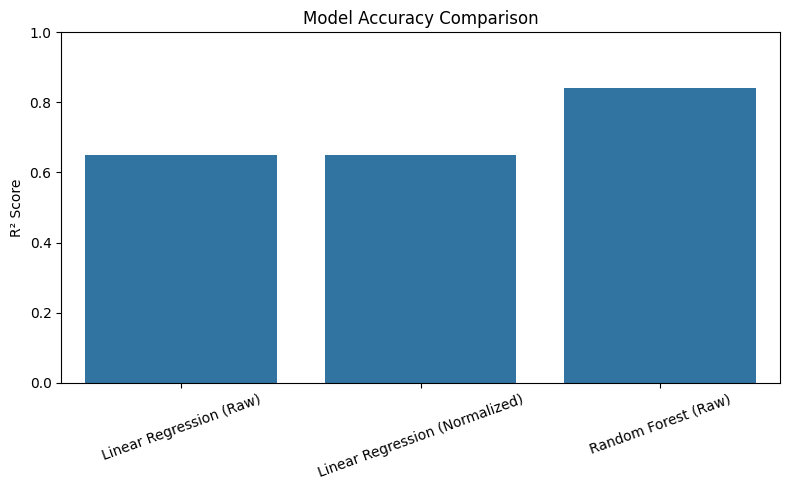

In [8]:
sample = X.iloc[[0]]
sample_scaled = scaler.transform(sample)

# Predict
lr_pred = lr.predict(sample_scaled)
rf_pred = rf.predict(sample)

print(f"Linear Regression (Log Target): Predicted House Value = {np.expm1(lr_pred[0]):,.0f}")
print(f"Random Forest (Log Target): Predicted House Value = {np.expm1(rf_pred[0]):,.0f}")

# Calculate R² scores (already calculated above, repeating here for clarity)
r2_lr = r2_score(y_test, lr_preds)  # Linear Regression with MinMaxScaler
r2_rf = r2_score(y_test, rf_preds)  # Random Forest on raw

# If you want a third comparison, e.g., Linear Regression without normalization:
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)
lr_raw_preds = lr_raw.predict(X_test)
r2_lr_raw = r2_score(y_test, lr_raw_preds)

# Plotting
models = ['Linear Regression (Raw)', 'Linear Regression (Normalized)', 'Random Forest (Raw)']
accuracies = [r2_lr_raw, r2_lr, r2_rf]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=accuracies)
plt.ylabel("R² Score")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

## Conclusion
- Normalization improves performance of linear models significantly.
- Random Forest is more robust to raw/unscaled features.
- Log transformation of skewed target helps improve performance in both cases.

### Bonus: Notes
- You can also try Box-Cox transformation instead of log.
- PCA can be attempted post-scaling to reduce dimensions.